<a href="https://colab.research.google.com/github/bieri2/ATMS-597-Project-4-Wx-Prediction/blob/master/GroupE_Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import necessary modules
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## KCMI Observations

In [0]:
# Read in daily KCMI data 
kcmi_daily = pd.read_csv('/content/drive/My Drive/project4_data/KCMI_daily.csv', 
                         header = 5, names = ['Timestamp', 'TMAXOBS', 'TMINOBS', 
                                              'WMAXOBS', 'RTOTOBS', 'extra'],
                         dtype = {'TMAXOBS': np.float64, 
                                  'TMINOBS': np.float64, 
                                  'WMAXOBS': np.float64, 
                                  'RTOTOBS': np.float64}, 
                         na_values = 'M')[:-7]
# Drop unnecessary column
kcmi_daily = kcmi_daily.drop(columns = 'extra')
# Set 'Date' column as index
kcmi_daily = kcmi_daily.set_index(pd.to_datetime(kcmi_daily['Timestamp'])).drop(columns = 'Timestamp')
# Resample to fill in missing days with NaNs
kcmi_daily = kcmi_daily.resample('D').mean()

In [0]:
# Read in hourly KCMI data
kcmi_hourly = pd.read_csv('/content/drive/My Drive/project4_data/KCMI_hourly.csv', 
                          header = 0, names = ['Timestamp', 'TMPC', 'DWPC', 'PRES', 
                                               'WDIR', 'WSPD', 'SKCT', 'PRCP1', 
                                               'PRCP6'], 
                          dtype = {'TMPC' : np.float64, 
                                   'DWPC' : np.float64, 
                                   'PRES' : np.float64, 
                                   'WDIR' : np.float64,
                                   'WSPD' : np.float64, 
                                   'SKCT' : np.float64, 
                                   'PRCP1': np.float64, 
                                   'PRCP6': np.float64}, 
                          usecols = [0, 5, 6, 7, 8, 9, 10, 11, 12], na_values = 'M')
# Set 'Timestep' column as index
kcmi_hourly = kcmi_hourly.set_index(pd.to_datetime(kcmi_hourly['Timestamp'])).drop(columns = 'Timestamp')
# Consider only data for 2010 to 2019
kcmi_hourly = kcmi_hourly['2010-01-01':'2019-12-31']
# Set trace precipitation to NaN
kcmi_hourly['PRCP1'][kcmi_hourly['PRCP1'] < 0] = np.NaN

In [0]:
# Resample hourly data to daily by summing hourly values
kcmi_hourly_resampled = kcmi_hourly.resample('D').apply(lambda x: x.values.sum())

In [0]:
# Replace daily precip data with aggregated hourly data, since daily precip data is problematic
kcmi_daily['RTOTOBS'] = kcmi_hourly_resampled['PRCP1'].astype('float')

In [0]:
# Convert observations to metric units if necessary
kcmi_daily['TMAXOBS'] = (kcmi_daily['TMAXOBS'] - 32.)/1.8 # F to C
kcmi_daily['TMINOBS'] = (kcmi_daily['TMINOBS'] - 32.)/1.8 # F to C
kcmi_daily['WMAXOBS'] = kcmi_daily['WMAXOBS']/2.237 # mph to m/s

In [0]:
# Get data for 2019 to use for validation
kcmi_2019  = kcmi_daily['2019-01-01':'2019-12-31']
# Get data from 2010 to 2018 to use for training
kcmi_train = kcmi_daily['2010-01-01':'2018-12-31']

## GFS Data

In [0]:
# Code to decompress tar.gz files and add to directory
# Only need to do this once, afterwards just need to read from Drive
# Change paths/filenames as needed

# ! mkdir '/content/drive/My Drive/project4_data/sfc_tar'
# ! gunzip '/content/drive/My Drive/project4_data/sfc.tar.gz' 
# ! tar -xvf '/content/drive/My Drive/project4_data/sfc.tar' --directory '/content/drive/My Drive/project4_data/sfc_tar'

In [0]:
# Paths to files for different GFS datasets
# Change as needed
gfs_daily_dir = '/content/drive/My Drive/project4_data/daily_tar/bufkit/' # Daily GFS data
gfs_prof_dir  = '/content/drive/My Drive/project4_data/prof_tar/bufkit/'  # GFS 3-hr vertical profile (not currently used)
gfs_sfc_dir   = '/content/drive/My Drive/project4_data/sfc_tar/bufkit/'   # GFS 3-hr surface data (not currently used)

In [0]:
# Define function to read in GFS daily data one day at a time
# Once all files have been read, combine into one DataFrame 
def get_gfs_data(gfs_dir, prof = False):

  # Get list of files to be read
  files = os.listdir(gfs_dir)
  # Sort so that files are in order by date
  files.sort()
  # Create list of full paths for all files
  file_list = [gfs_dir + f for f in files]

  # Create empty list to hold data
  if prof:
      all_dwpc = []
      all_hght = []
      all_tmpc = []
      all_uwnd = []
      all_vwnd = [] 
  else:
      all_dfs  = []


  # Read in each file and add to list
  for f in file_list: 
      # Tell user which file is being read
      print('Reading ' + f)

      if prof:
          current = pd.read_csv(f, index_col = 0, header = 0,
                                names = ['Timestep', 'DWPC', 'HGHT', 
                                         'PRES', 'TMPC', 'UWND', 'VWND'])  
         # print(current['PRES'])

          for i in current.index:
              dwpc_current = pd.DataFrame(current['DWPC'][i][1:-1].split(',')).T
              dwpc_current['Timestep'] = [dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S')]
              dwpc_current = dwpc_current.set_index('Timestep')
              dwpc_current = dwpc_current.rename(columns = {0:'925', 1:'850', 2:'700', 
                                                            3:'500', 4:'250', 5:'100'})
              all_dwpc.append(dwpc_current) 

              hght_current = pd.DataFrame(current['HGHT'][i][1:-1].split(',')).T 
              hght_current['Timestep'] = [dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S')]
              hght_current = hght_current.set_index('Timestep')
              hght_current = hght_current.rename(columns = {0:'925', 1:'850', 2:'700', 
                                                            3:'500', 4:'250', 5:'100'})
              all_hght.append(hght_current) 

              tmpc_current = pd.DataFrame(current['TMPC'][i][1:-1].split(',')).T 
              tmpc_current['Timestep'] = [dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S')]
              tmpc_current = tmpc_current.set_index('Timestep')
              tmpc_current = tmpc_current.rename(columns = {0:'925', 1:'850', 2:'700', 
                                                            3:'500', 4:'250', 5:'100'})
              all_tmpc.append(tmpc_current) 

              uwnd_current = pd.DataFrame(current['UWND'][i][1:-1].split(',')).T 
              uwnd_current['Timestep'] = [dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S')]
              uwnd_current = uwnd_current.set_index('Timestep')
              uwnd_current = uwnd_current.rename(columns = {0:'925', 1:'850', 2:'700', 
                                                            3:'500', 4:'250', 5:'100'})
              all_uwnd.append(uwnd_current) 

              vwnd_current = pd.DataFrame(current['VWND'][i][1:-1].split(',')).T 
              vwnd_current['Timestep'] = [dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S')]
              vwnd_current = vwnd_current.set_index('Timestep')
              vwnd_current = vwnd_current.rename(columns = {0:'925', 1:'850', 2:'700', 
                                                            3:'500', 4:'250', 5:'100'})
              all_vwnd.append(vwnd_current) 

      else:
          current = pd.read_csv(f)
          current = current.rename(columns={'Unnamed: 0': 'Timestamp', 
                                      'TMAX': 'TMAXGFS',
                                      'TMIN': 'TMINGFS',
                                      'WMAX': 'WMAXGFS', 
                                      'RTOT': 'RTOTGFS'})
          # Set timestamp as index
          current = current.set_index(pd.to_datetime(current['Timestamp'])).drop(columns = 'Timestamp')

          all_dfs.append(current) 

  if prof:
      all_dwpc = pd.concat(all_dwpc).astype(np.float64)
      all_hght = pd.concat(all_hght).astype(np.float64)
      all_tmpc = pd.concat(all_tmpc).astype(np.float64)
      all_uwnd = pd.concat(all_uwnd).astype(np.float64)
      all_vwnd = pd.concat(all_vwnd).astype(np.float64)

      return [all_dwpc, all_hght, all_tmpc, all_uwnd, all_vwnd]

  else: 
      # Create one DataFrame with all data 
      all_dfs = pd.concat(all_dfs).astype(np.float64)

      return all_dfs

In [0]:
# Read in profile GFS data
dwpc, hght, tmpc, uwnd, vwnd = get_gfs_data(gfs_prof_dir, prof = True)

In [0]:
# Read in daily GFS data
# This will take several minutes the first time but will be a lot faster if run again without restarting runtime
gfs_daily = get_gfs_data(gfs_daily_dir)

In [0]:
# Resample to fill any missing days
gfs_daily = gfs_daily.resample('D').mean()

In [0]:
# Increase all dates in GFS data indices by one day since GFS forecasts apply to the following day
gfs_daily = gfs_daily.set_index(gfs_daily.index + pd.Timedelta(days = 1))

In [0]:
# Separate into training and validation datasets
gfs_2019  = gfs_daily['2019-01-01':'2019-12-31']
gfs_train = gfs_daily['2010-01-02':'2018-12-31']

## Prediction via regression

In [0]:
# Create one dataframe with observations and GFS data for training
# Trim off first day of observations to match GFS data
# Trim off last day of GFS data to exclude extra timestep
all_train_data  = pd.concat([kcmi_train['2010-01-02':], gfs_train], 
                            axis = 1)

all_test_data   = pd.concat([kcmi_2019, gfs_2019], axis = 1) 

In [0]:
# Drop missing values
# Doing this because regression function does not handle NaNs
all_train_data = all_train_data.dropna()
all_test_data  = all_test_data.dropna()

In [0]:
# Define function to apply regression to input dataframe
def reg_predict(x, y, predict):
    model = LinearRegression(fit_intercept = True, normalize = True)  
    model.fit(x, y)
    train, predict = model.predict(x), model.predict(predict)
    return train, predict

In [0]:
# Get predicted values using training data (_predict) and predicted values for 2019 (_predict19) 
# 2019 predictions will be compared to 2019 observations
Tmax_predict, Tmax_predict19     = reg_predict(all_train_data[['TMAXGFS']], 
                                               all_train_data[['TMAXOBS']], all_test_data[['TMAXGFS']])
Tmin_predict, Tmin_predict19     = reg_predict(all_train_data[['TMINGFS']],
                                               all_train_data[['TMINOBS']], all_test_data[['TMINGFS']])
Wmax_predict, Wmax_predict19     = reg_predict(all_train_data[['WMAXGFS']],
                                               all_train_data[['WMAXOBS']], all_test_data[['WMAXGFS']])
Precip_predict, Precip_predict19 = reg_predict(all_train_data[['RTOTGFS']],
                                               all_train_data[['RTOTOBS']], all_test_data[['RTOTGFS']])

In [0]:
%matplotlib inline
sns.set_style('ticks')

# Define function to plot actual vs. predicted values
def plot_predict(time, actual, predicted, colors, legendloc, title, ylabel, ymin, ymax):
    # Dashed vertical line denotes beginning of 2019

    plt.figure(figsize=(15,5))
    plt.plot(time, actual, color = colors[0], label = 'Observed')
    plt.plot(time, predicted, color = colors[1], alpha = 0.8, label = 'Predicted')
    plt.vlines(dt.datetime(2019, 1, 1), ymin, ymax, linestyles = 'dashed', alpha = 0.7)
    plt.legend(loc = legendloc)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Time')
    plt.xlim(time[0]-pd.Timedelta(days=1),  time[-1]+pd.Timedelta(days=1))
    plt.ylim(ymin, ymax)
    plt.show()

In [0]:
time = np.concatenate((all_train_data.index.values, all_test_data.index.values))

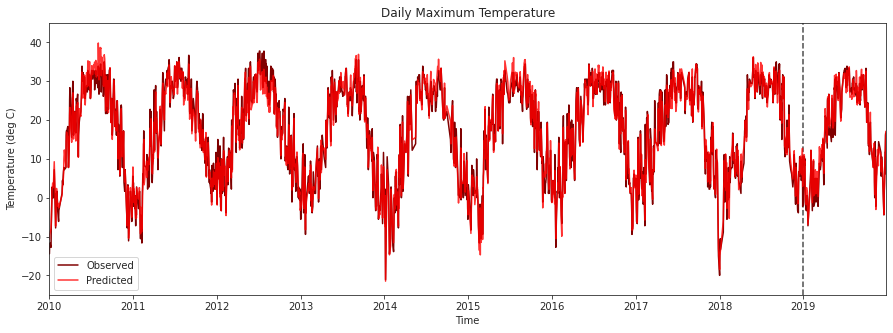

In [0]:
# Plot predicted vs. actual Tmax
Tmax_actual    = np.concatenate((all_train_data['TMAXOBS'].values, all_test_data['TMAXOBS'].values))
Tmax_predicted = np.concatenate((Tmax_predict, Tmax_predict19))
colors = ['maroon', 'red']
plot_predict(time, Tmax_actual, Tmax_predicted, colors, legendloc = 'lower left', 
             title = 'Daily Maximum Temperature', ylabel = 'Temperature (deg C)', 
             ymin = -25, ymax = 45)

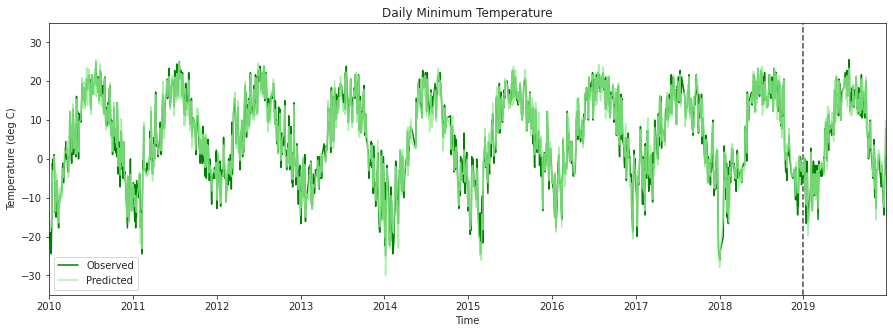

In [0]:
# Plot predicted vs. actual Tmin

Tmin_actual    = np.concatenate((all_train_data['TMINOBS'].values, all_test_data['TMINOBS'].values))
Tmin_predicted = np.concatenate((Tmin_predict, Tmin_predict19))
colors = ['green', 'lightgreen']
plot_predict(time, Tmin_actual, Tmin_predicted, colors, legendloc = 'lower left', 
             title = 'Daily Minimum Temperature', ylabel = 'Temperature (deg C)', 
             ymin = -35, ymax = 35)

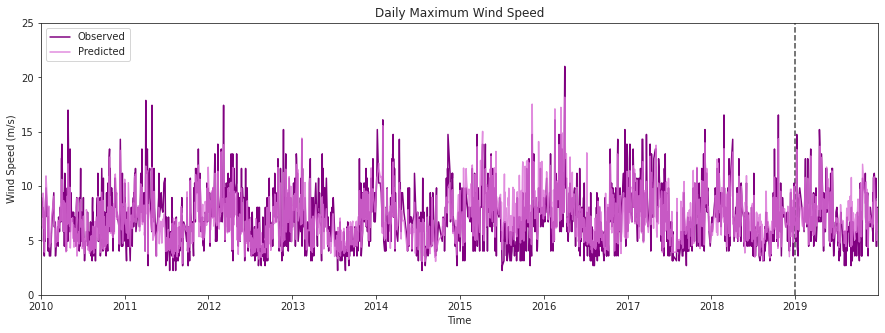

In [0]:
# Plot predicted vs. actual Wmax

Wmax_actual    = np.concatenate((all_train_data['WMAXOBS'].values, all_test_data['WMAXOBS'].values))
Wmax_predicted = np.concatenate((Wmax_predict, Wmax_predict19))
colors = ['purple', 'orchid']
plot_predict(time, Wmax_actual, Wmax_predicted, colors, legendloc = 'upper left', 
             title = 'Daily Maximum Wind Speed', ylabel = 'Wind Speed (m/s)', 
             ymin = 0, ymax = 25)

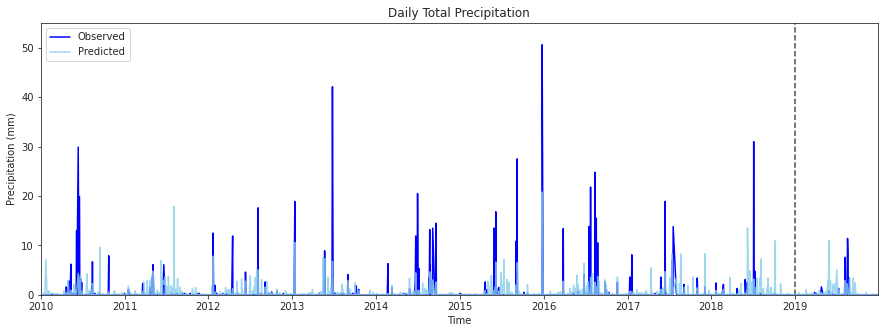

In [0]:
# Plot predicted vs. actual Precip

Precip_actual    = np.concatenate((all_train_data['RTOTOBS'].values, all_test_data['RTOTOBS'].values))
Precip_predicted = np.concatenate((Precip_predict, Precip_predict19))
colors = ['blue', 'skyblue']
plot_predict(time, Precip_actual, Precip_predicted, colors, legendloc = 'upper left', 
             title = 'Daily Total Precipitation', ylabel = 'Precipitation (mm)', 
             ymin = 0, ymax = 55)